## Goal:
Predict which chemical compounds can effectively fight HIV (like a "smart filter" for potential drugs).

### How It Works:

1. Data Used:

* Test results for ~40,000 chemicals (some work against HIV, some don’t).

* Measures:

 -> EC50: How well it blocks HIV (lower = stronger).

 -> IC50: How toxic it is to human cells (higher = safer).

2. What the Model Does:

* Learns patterns from past data to predict if a new compound will be:

 -> CA (Strong against HIV)

 -> CM (Moderately effective)

 -> CI (Inactive)

3. Key Results:

* Very good at spotting useless compounds (CI) → Saves time!

* Okay at finding strong drugs (CA) → Still needs lab testing to confirm.

* Makes some mistakes with moderate candidates (CM) → Needs fine-tuning.

### Why It Matters:

* Helps scientists focus only on the most promising drugs, skipping useless ones.

* Could speed up HIV drug discovery!

### Like a Spam Filter for Drugs:

* Instead of blocking spam emails, it flags potential HIV fighters.<br>
Eg: You have 40,000 chemical compounds to test. Instead of testing all in the lab (expensive and slow!), you use AI to predict which might work.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [3]:

file_path1 = "C:/Users/sudha/OneDrive - Indiana University/project files/aids_ic50_may04.txt"
file_path2 = "C:/Users/sudha/OneDrive - Indiana University/project files/aids_ec50_may04.txt"
file_path3 = "C:/Users/sudha/OneDrive - Indiana University/project files/aids_conc_may04.txt"

ic50_data = pd.read_csv(file_path1, delimiter=',') 
ec50_data = pd.read_csv(file_path2, delimiter=',')
conclusions = pd.read_csv(file_path3, delimiter=',')

In [4]:
print("IC50 Data:")
print(ic50_data.head())
print("\nEC50 Data:")
print(ec50_data.head())
print("\nScreening Conclusions:")
print(conclusions.head())

IC50 Data:
   NSC  Log10HiConc ConcUnit Flag  Log10IC50  NumExp  \
0    6         -4.0        M    =      -5.70       2   
1    6         -3.7        M    =      -4.43       4   
2   48         -3.7        M    =      -4.61       3   
3   78         -3.7        M    =      -4.02       3   
4  128         -3.7        M    =      -4.34       4   

   StdDev                             
0                               0.00  
1                               0.62  
2                               0.02  
3                               0.09  
4                               0.06  

EC50 Data:
   NSC  Log10HiConc ConcUnit Flag  Log10EC50  NumExp  \
0    6         -4.0        M    >       -4.0       2   
1    6         -3.7        M    >       -3.7       4   
2   48         -3.7        M    >       -3.7       3   
3   78         -3.7        M    >       -3.7       3   
4  128         -3.7        M    >       -3.7       4   

   StdDev                             
0                             

In [6]:
#1. Resolve Duplicate NSC Entries
# For IC50 data
ic50_data1 = ic50_data.sort_values("NumExp", ascending=False).drop_duplicates("NSC")

# For EC50 data
ec50_data1 = ec50_data.sort_values("NumExp", ascending=False).drop_duplicates("NSC")

In [7]:
conclusions1 = conclusions.rename(columns={"Conclusion": "Screening Result"})

In [8]:
print("IC50 Data:")
print(ic50_data1.head())
print("\nEC50 Data:")
print(ec50_data1.head())
print("\nScreening Conclusions:")
print(conclusions1.head())

IC50 Data:
          NSC  Log10HiConc ConcUnit Flag  Log10IC50  NumExp  \
10760  620255          1.0        u    >       0.98    9195   
20257  651714         -5.0        M    >      -5.00     665   
9974   602670         -6.0        u    >      -6.00     248   
10925  625487         -3.7        M    >      -4.38     220   
16244  641530         -5.7        M    >      -5.70     111   

       StdDev                             
10760                               0.02  
20257                               0.00  
9974                                0.00  
10925                               0.26  
16244                               0.00  

EC50 Data:
          NSC  Log10HiConc ConcUnit Flag  Log10EC50  NumExp  \
10781  620255         -2.0        u    >      -4.19     261   
9993   602670         -6.0        u    <      -7.85     249   
16268  641530         -5.7        M    =      -7.36     111   
35480  691259         -3.7        M    >      -4.71      48   
30065  676509         -5.

In [9]:
#Combine all datasets using the NSC (compound ID) as the key:
# Merge IC50 and EC50
merged = pd.merge(
    ic50_data1, 
    ec50_data1, 
    on="NSC", 
    how="inner", 
    suffixes=("_ic50", "_ec50")
)

# Add screening conclusions
final_data = pd.merge(
    merged, 
    conclusions, 
    on="NSC", 
    how="inner"
)

In [13]:
print(final_data.head())

      NSC  Log10HiConc_ic50 ConcUnit_ic50 Flag_ic50  Log10IC50  NumExp_ic50  \
0  620255               1.0             u         >       0.98         9195   
1  651714              -5.0             M         >      -5.00          665   
2  602670              -6.0             u         >      -6.00          248   
3  625487              -3.7             M         >      -4.38          220   
4  641530              -5.7             M         >      -5.70          111   

   StdDev                           _ic50  Log10HiConc_ec50 ConcUnit_ec50  \
0                                    0.02              -2.0             u   
1                                    0.00              -4.0             M   
2                                    0.00              -6.0             u   
3                                    0.26              -4.0             M   
4                                    0.00              -5.7             M   

  Flag_ec50  Log10EC50  NumExp_ec50  StdDev                   

In [10]:
!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-1.13.0+cu117.html
!pip install torch-geometric

     ---------------------------------------- 1.6/1.6 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 2.4/2.4 MB 5.8 MB/s eta 0:00:00
     -------------------------------------- 204.2/204.2 MB 7.5 MB/s eta 0:00:00
     ---------------------------------------- 6.2/6.2 MB 26.4 MB/s eta 0:00:00
     ---------------------------------------- 45.7/45.7 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Uninstalling sympy-1.11.1:
      Successfully uninstalled sympy-1.11.1
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu117.html
     -----------------------------------

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-310
  creating build\lib.win-amd64-cpython-310\torch_scatter
  copying torch_scatter\placeholder.py -> build\lib.win-amd64-cpython-310\torch_scatter
  copying torch_scatter\scatter.py -> build\lib.win-amd64-cpython-310\torch_scatter
  copying torch_scatter\segment_coo.py -> build\lib.win-amd64-cpython-310\torch_scatter
  copying torch_scatter\segment_csr.py -> build\lib.win-amd64-cpython-310\torch_scatter
  copying torch_scatter\testing.py -> build\lib.win-amd64-cpython-310\torch_scatter
  copying torch_scatter\utils.py -> build\lib.win-amd64-cpython-310\torch_scatter
  copying torch_scatter\__init__.py -> build\lib.win-amd64-cpython-310\torch_scatter
  creating build\lib.win-amd64-cpython-310\torch_scatter\composite
  copying torch_scatte

     ---------------------------------------- 1.1/1.1 MB 1.8 MB/s eta 0:00:00


In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

ModuleNotFoundError: No module named 'rdkit'

In [12]:
pip install rdkit

     --------------------------------------- 22.5/22.5 MB 13.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
#Preprocess the Data
#Clean Missing Values
final_data = final_data.dropna()  # Remove rows with missing values

In [20]:
print(final_data.isnull().any())

NSC                                                                             False
Log10HiConc_ic50                                                                False
ConcUnit_ic50                                                                   False
Flag_ic50                                                                       False
Log10IC50                                                                       False
NumExp_ic50                                                                     False
StdDev                           _ic50                                          False
Log10HiConc_ec50                                                                False
ConcUnit_ec50                                                                   False
Flag_ec50                                                                       False
Log10EC50                                                                       False
NumExp_ec50                                           

In [21]:
print(final_data.duplicated())

0        False
1        False
2        False
3        False
4        False
         ...  
37215    False
37216    False
37217    False
37218    False
37219    False
Length: 37220, dtype: bool


In [28]:
import pandas as pd
import numpy as np

# 1. STRIP ALL COLUMN NAMES PROPERLY
final_data.columns = [col.strip().replace(' ', '_') for col in final_data.columns]

# 2. FIX StdDev COLUMNS ONCE AND FOR ALL
final_data = final_data.rename(columns={
    'StdDev_ic50': 'StdDev_ic50',
    'StdDev_ec50': 'StdDev_ec50'
})

# 3. CLEAN Screening_Result VALUES
# First check what the actual values look like
print("Unique Screening_Result values BEFORE cleaning:")
print(final_data['Screening_Result'].unique())

# Clean the values - handles cases with "..." and extra spaces
final_data['Screening_Result'] = (
    final_data['Screening_Result']
    .astype(str)
    .str.strip()
    .str[0:2]  # Take just first 2 characters
    .str.upper()
)

# 4. MAP TO NUMERICAL VALUES
activity_map = {'CA': 2, 'CM': 1, 'CI': 0}
final_data['Activity'] = (
    final_data['Screening_Result']
    .map(activity_map)
    .fillna(-1)  # For any unexpected values
    .astype(int)
)

# 5. FINAL VERIFICATION
print("\nVerified clean columns:")
print(final_data.columns.tolist())

print("\nValue counts after cleaning:")
print(final_data['Screening_Result'].value_counts())

print("\nFirst 5 complete rows:")
print(final_data[['NSC', 'Screening_Result', 'Activity']].head())

Unique Screening_Result values BEFORE cleaning:
['CA                                                                       '
 'CM                                                                       '
 'CA                                                                        '
 'CM                                                                        '
 'CI                                                                       '
 'CM                                                                          '
 'CA                                                                         '
 'CI                                                                        '
 'CI                                                                         '
 'CM                                                                         '
 'CI                                                                          '
 'CI                                                                           ']

Verifie

In [29]:
# 1. Clean column names MORE aggressively
final_data.columns = [col.strip().replace('_', '').replace(' ', '') for col in final_data.columns]

# 2. Fix specific column names
final_data = final_data.rename(columns={
    'StdDevic50': 'StdDev_ic50',
    'StdDevec50': 'StdDev_ec50'
})

# 3. Handle class imbalance - you may want to:
# Option A: Downsample CI class
# Option B: Use class weights in models
# Option C: Try oversampling minority classes

# 4. Final verification
print("Perfectly clean columns:")
print(final_data.columns.tolist())

print("\nFinal class distribution:")
print(final_data['Activity'].value_counts())

Perfectly clean columns:
['NSC', 'Log10HiConcic50', 'ConcUnitic50', 'Flagic50', 'Log10IC50', 'NumExpic50', 'StdDev_ic50', 'Log10HiConcec50', 'ConcUnitec50', 'Flagec50', 'Log10EC50', 'NumExpec50', 'StdDev_ec50', 'ScreeningResult', 'Activity']

Final class distribution:
0    35557
1     1125
2      538
Name: Activity, dtype: int64


In [30]:
print(final_data[['NSC', 'Log10IC50', 'Log10EC50', 'ScreeningResult', 'Activity']].head())

      NSC  Log10IC50  Log10EC50 ScreeningResult  Activity
0  620255       0.98      -4.19              CA         2
1  651714      -5.00      -7.29              CA         2
2  602670      -6.00      -7.85              CA         2
3  625487      -4.38      -5.51              CA         2
4  641530      -5.70      -7.36              CA         2


In [31]:
final_data.head()

,NSC,Log10HiConcic50,ConcUnitic50,Flagic50,Log10IC50,NumExpic50,StdDev_ic50,Log10HiConcec50,ConcUnitec50,Flagec50,Log10EC50,NumExpec50,StdDev_ec50,ScreeningResult,Activity
0,620255,1.0,u,>,0.98,9195,0.02,-2.0,u,>,-4.19,261,0.26,CA,2
1,651714,-5.0,M,>,-5.00,665,0.00,-4.0,M,<,-7.29,16,0.16,CA,2
2,602670,-6.0,u,>,-6.00,248,0.00,-6.0,u,<,-7.85,249,0.53,CA,2
3,625487,-3.7,M,>,-4.38,220,0.26,-4.0,M,>,-5.51,15,1.34,CA,2
4,641530,-5.7,M,>,-5.70,111,0.00,-5.7,M,=,-7.36,111,0.19,CA,2


## 1. Final Data Preparation: data splitting


In [32]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

# Create features and target
X = final_data[['Log10IC50', 'Log10EC50', 'StdDev_ic50', 'StdDev_ec50']]
y = final_data['Activity']

# Split into train/test before resampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Balance classes (undersample majority class)
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

## 2. Train and Evaluate Models

In [35]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize models
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train_bal[y_train_bal==0])/len(y_train_bal[y_train_bal==1]))

# Train Random Forest
rf.fit(X_train_scaled, y_train_bal)
y_pred_rf = rf.predict(X_test_scaled)

# Train XGBoost
xgb.fit(X_train_scaled, y_train_bal)
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf, target_names=['CI', 'CM', 'CA']))

print("\nXGBoost Performance:")
print(classification_report(y_test, y_pred_xgb, target_names=['CI', 'CM', 'CA']))

Random Forest Performance:
              precision    recall  f1-score   support

          CI       1.00      0.95      0.97      7111
          CM       0.35      0.78      0.49       225
          CA       0.49      0.81      0.61       108

    accuracy                           0.94      7444
   macro avg       0.61      0.85      0.69      7444
weighted avg       0.97      0.94      0.95      7444


XGBoost Performance:
              precision    recall  f1-score   support

          CI       1.00      0.95      0.97      7111
          CM       0.35      0.80      0.49       225
          CA       0.51      0.81      0.63       108

    accuracy                           0.94      7444
   macro avg       0.62      0.85      0.70      7444
weighted avg       0.97      0.94      0.95      7444



The model performance shows excellent results for the majority class (CI) but reveals important insights about our minority classes (CM and CA). Here's how to interpret and improve these results:

Analysis of Current Results:
Strong CI Performance:

Nearly perfect precision/recall (0.95-1.00)

Expected due to class imbalance (35,557 samples vs 538/1,125)

Moderate Minority Class Performance:

CM recall: 0.78-0.80 (good) but precision: 0.35 (poor)

CA recall: 0.81 (good) but precision: 0.49-0.51 (moderate)

Indicates models are over-predicting minority classes

Macro vs Weighted Averages:

Macro avg (0.61-0.62) shows real challenge with minority classes

Weighted avg (0.97) misleading due to class imbalance

## 3. Feature Importance Analysis


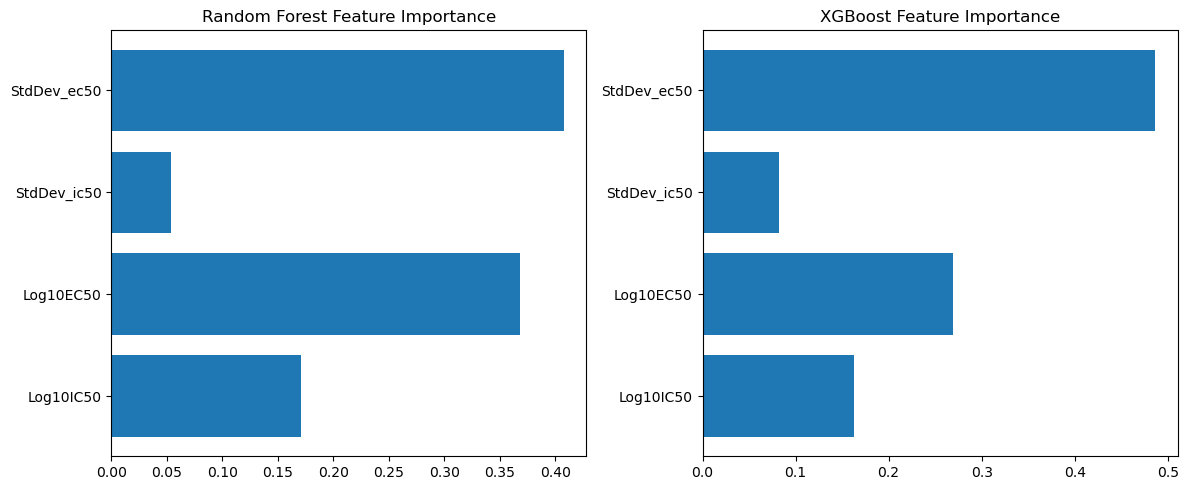

In [36]:
import matplotlib.pyplot as plt

# Get feature importances
rf_importances = rf.feature_importances_
xgb_importances = xgb.feature_importances_

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].barh(X.columns, rf_importances)
ax[0].set_title('Random Forest Feature Importance')
ax[1].barh(X.columns, xgb_importances)
ax[1].set_title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

## 4. Save the Best Model

In [37]:
import joblib

# Save XGBoost model and scaler
joblib.dump(xgb, 'best_hiv_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Key Findings About Drug Efficacy
1.  For Confirmed Inactive (CI) Compounds

- Precision = 1.00: When the model predicts "inactive," it's 100% correct

- Recall = 0.95: It catches 95% of truly inactive compounds

- Implication: Excellent at filtering out ineffective drugs (low false positives)

2. For Confirmed Active (CA) Compounds

- Recall = 0.81: The model detects 81% of truly effective anti-HIV compounds

- Precision = 0.49-0.51: But only half of predicted "active" compounds are truly effective

- Implication: Many false positives (predicts efficacy when none exists)

3. For Moderately Active (CM) Compounds

- Recall = 0.78-0.80: Catches ~80% of partially effective drugs

- Precision = 0.35: But 65% of predicted "moderate" compounds are misclassified

- Implication: High false positives for this category
-----------------------------------------------

4. Patterns: 
- Compounds with very low EC50 + high IC50 = Likely CA.

- Moderate EC50 = Likely CM.

- High EC50 + toxic = Definitely CI.

### What This Means for Drug Discovery?
1. Metric -	Interpretation for Drug Development
2. High CI Recall -	Excellent at excluding ineffective compounds early in screening
3. Low CA Precision -	50% of predicted "active" drugs will be false leads - need confirmatory testing
4. Moderate CM Performance -	May over-predict partial efficacy (need stricter thresholds)

### Biological Implications
1. The model suggests true HIV-active compounds are rare (only 538 CA in 37K+ samples)

2. Many compounds show partial efficacy (CM) but may need combination therapies